In [1]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np



from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
tf.__version__

'2.2.0-rc3'

In [2]:
from nltk.tokenize import TweetTokenizer
tknzr_TweetTokenizer = TweetTokenizer(strip_handles=False, reduce_len=True)

from nltk.tokenize.destructive import NLTKWordTokenizer
tknzr_NLTKWordTokenizer = NLTKWordTokenizer()

# from nltk.tokenize import MWETokenizer
# tknzr = MWETokenizer()
from nltk.tokenize import WordPunctTokenizer
tknzr_WordPunctTokenizer = WordPunctTokenizer()



text = "Estou.torcendo :) poooooor: todos nós :( "
print( "tknzr_WordPunctTokenizer ...:", tknzr_WordPunctTokenizer.tokenize(text.lower()) )
print( "tknzr_NLTKWordTokenizer ....:", tknzr_NLTKWordTokenizer.tokenize(text.lower()) )
print( "tknzr_TweetTokenizer .......:", tknzr_TweetTokenizer.tokenize(text.lower()) )

' '.join(tknzr_WordPunctTokenizer.tokenize(text.lower()))


tknzr_WordPunctTokenizer ...: ['estou', '.', 'torcendo', ':)', 'poooooor', ':', 'todos', 'nós', ':(']
tknzr_NLTKWordTokenizer ....: ['estou.torcendo', ':', ')', 'poooooor', ':', 'todos', 'nós', ':', '(']
tknzr_TweetTokenizer .......: ['estou.torcendo', ':)', 'pooor', ':', 'todos', 'nós', ':(']


'estou . torcendo :) poooooor : todos nós :('

In [3]:
# Definindo as variáveis do projeto
vocab_size = 200000  # Considerar 200k palavras
maxlen = 200  # Considerar apenas as 100 primeiras palavras do texto da review

embed_dim = 50 # tamanho do Embedding de cada token ( também do word2vec da NILC)
num_heads = 2  # N. de cabeças de atenção
ff_dim = 32   # tamanho da camada oculta nas redes feed forward dentro do transformer

# Path para o arquivo de dados da b2w
# B2W_DATAFILE = "/home/wseidel/workspaces/usp/b2w-reviews01/B2W-Reviews01.csv"
B2W_DATAFILE = "/home/wesley/workspaces/usp/data/b2w/B2W-Reviews01.csv"
# B2W_DATAFILE = "/home/wseidel/workspaces/usp/b2w-reviews01/B2W-10k.csv"


# Path para o arquivo de dados de embeddings do NILC
# NILC_W2V_DATAFILE = "/home/wseidel/workspaces/usp/NILC/word2vec_200k.txt"
NILC_W2V_DATAFILE = "/home/wesley/workspaces/usp/data/nilc/word2vec_200k.txt"

# Quantidade de epocas para o treino
QNT_EPOCAS_A_TREINAR = 2

In [4]:
# Carregar dados a serem analisados
b2wCorpus = pd.read_csv(B2W_DATAFILE, sep=';', usecols=["review_text", "overall_rating"])

# Carregar o Word2Vec do NILC
# model_w2v = KeyedVectors.load_word2vec_format(NILC_W2V_DATAFILE)

In [5]:
def train_test_val_split(dataset, train_size=0.6, test_size=0.3, colname_stratify='overall_rating',random_seed=29):
    val_size = 1 - round((train_size + test_size),1)
    split_train_test_size = test_size + val_size

    train, val = train_test_split(dataset, 
                                  test_size=split_train_test_size, 
                                  stratify=dataset[colname_stratify], 
                                  random_state=random_seed)

    test, val = train_test_split(val, 
                                  test_size=val_size/split_train_test_size, 
                                  stratify=val[colname_stratify], 
                                  random_state=random_seed)
    return train.reset_index(drop=True), test, val

def sort_by_size(df, col_to_sort):
    df['sentence_length'] = df[col_to_sort].apply(lambda x: len(x.split()))
    df.sort_values(by=['sentence_length'], inplace=True, ignore_index=True)
    return df

def getXY(serieX, serieY, padding_maxlen=50):
#     x_train = keras.preprocessing.sequence.pad_sequences(train['review_text_clean'], maxlen=padding_maxlen, padding='post')
    x_ = serieX.values
    y_ = serieY.values
    return x_, y_



# train, test, val = train_test_val_split(df_to_work, train_size=0.75, test_size=0.15)
df_to_work = b2wCorpus

TAMMAX_SENTENCE=50
# MAX_SEQUENCE_LENGTH = 50
VOCAB_SIZE = 20000

values_to_retain=[1,2,3,4,5]
df_to_work = df_to_work[df_to_work['overall_rating'].isin(values_to_retain)]
# df_to_work
df_to_work['overall_rating'] = df_to_work.overall_rating.apply(lambda x: x-1)

# # Aplicando o sentence_to_nilc_index_token
# df_to_work['review_text_clean'] = df_to_work.review_text.apply(lambda x: sentence_to_nilc_index_token(x))

df_to_work['review_text'] = df_to_work.review_text.apply(lambda x: ' '.join(tknzr_WordPunctTokenizer.tokenize(x.lower())))

train, test, val = train_test_val_split(df_to_work)

sort_by_size(train, 'review_text')


x_train, y_train = getXY(train['review_text'], train['overall_rating'])
x_test,  y_test  = getXY(test['review_text'], test['overall_rating'])
x_val,   y_val   = getXY(val['review_text'], val['overall_rating'])


print("train..:", len(train), round(len(train) / len(df_to_work),3) ) 
print("test...:", len(test), round(len(test) / len(df_to_work),3) )
print("val....:", len(val), round(len(val) / len(df_to_work),3) )
print("--" * 20) 
print("x_train..:", len(x_train), "Last value(Y,X)..: [", y_train[-1], "] ", x_train[-1] )
print("x_test...:", len(x_test),  "Last value(Y,X)..: [", y_test[-1], "] ", x_test[-1] )
print("x_val....:", len(x_val),  "Last value(Y,X)..: [", y_val[-1], "] ", x_val[-1] )

train..: 79423 0.6
test...: 39712 0.3
val....: 13238 0.1
----------------------------------------
x_train..: 79423 Last value(Y,X)..: [ 2 ]  pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto pena que não tem desconto p

In [6]:
VOCAB_SIZE=2000

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens= VOCAB_SIZE,#MAX_TOKENS,
    standardize= 'lower_and_strip_punctuation', # None
#     standardize=
    output_mode='int', # "int", "binary", "count" or "tf-idf",
    output_sequence_length= 50#MAX_SENTENCE_LENGTH,  # Only valid in INT mode.
)

vectorize_layer.adapt(x_train)

In [19]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(vocab_size=1000, dropout_prob=0.0):
#     embedding_layer = model_w2v.get_keras_embedding()
#     embedding_layer.trainable = True

    model = keras.Sequential()
#     model.add(layers.Input(shape=(TAMMAX_SENTENCE, )))
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(layers.Embedding(vocab_size+1, 50, input_length=TAMMAX_SENTENCE))
#     model.add(embedding_layer)
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(dropout_prob))
    model.add(keras.layers.Dense(5, activation='softmax'))
    
    return model

model = get_model( vocab_size=VOCAB_SIZE, dropout_prob=0.5)

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            100050    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 129,815
Trainable params: 129,815
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Exemplo a implementar
# name = 'm1_lstm_drop0.0'
# model = get_lstm_model(dropout_prob=0.5)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# mc = ModelCheckpoint('../model_data/' + name + 'best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks=[es, mc])
# save_history(history, name)
# model.evaluate(x_test, y_test)
# display_loss_plot(history, name)
# display_acc_plot(history, name)

In [20]:
# Ver lista06

# Ler aqui pro batch generator:
#     https://datascience.stackexchange.com/questions/48796/how-to-feed-lstm-with-different-input-array-sizes

# Seu código aqui

QNT_EPOCAS_TREINO = 50

history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    epochs=QNT_EPOCAS_TREINO, 
    validation_data=(x_val, y_val)
)

loss, accuracy = model.evaluate(x=x_test,y=y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/50
2482/2482 [==============================] - 70s 28ms/step - loss: 1.0636 - accuracy: 0.5405 - val_loss: 0.9772 - val_accuracy: 0.5727
Epoch 2/50
2482/2482 [==============================] - 69s 28ms/step - loss: 0.9624 - accuracy: 0.5872 - val_loss: 0.9465 - val_accuracy: 0.5967
Epoch 3/50
2482/2482 [==============================] - 70s 28ms/step - loss: 0.9267 - accuracy: 0.6010 - val_loss: 0.9442 - val_accuracy: 0.6030
Epoch 4/50
2482/2482 [==============================] - 70s 28ms/step - loss: 0.9015 - accuracy: 0.6116 - val_loss: 0.9231 - val_accuracy: 0.6083
Epoch 5/50
2482/2482 [==============================] - 70s 28ms/step - loss: 0.8804 - accuracy: 0.6184 - val_loss: 0.9126 - val_accuracy: 0.6091
Epoch 6/50
2482/2482 [==============================] - 67s 27ms/step - loss: 0.8654 - accuracy: 0.6265 - val_loss: 0.9190 - val_accuracy: 0.6024
Epoch 7/50
2482/2482 [==============================] - 67s 27ms/step - loss: 0.8488 - accuracy: 0.6315 - val_loss: 0.9292 -

# Comparações 

## configs:
 - LSTM = 32
 - vocab_size = 1000
 - Embeddind = Zerado
 - Tokenizer padrão do TextVectorization
    
```
Epoch 1/3
2482/2482 [==============================] - 53s 21ms/step - loss: 1.0628 - accuracy: 0.5413 - val_loss: 0.9851 - val_accuracy: 0.5830
Epoch 2/3
2482/2482 [==============================] - 54s 22ms/step - loss: 0.9624 - accuracy: 0.5881 - val_loss: 0.9556 - val_accuracy: 0.5934
Epoch 3/3
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9346 - accuracy: 0.5976 - val_loss: 0.9435 - val_accuracy: 0.5968
1241/1241 [==============================] - 8s 7ms/step - loss: 0.9454 - accuracy: 0.5933
Loss:  0.9453516602516174
Accuracy:  0.5933470726013184
```

## configs:
 - LSTM = 32
 - vocab_size = 1000
 - Embeddind = Zerado
 - tknzr_WordPunctTokenizer (NLTK) + Tokenizer padrão do TextVectorization 
    
```
Epoch 1/10
2482/2482 [==============================] - 56s 23ms/step - loss: 1.0530 - accuracy: 0.5473 - val_loss: 0.9864 - val_accuracy: 0.5678
Epoch 2/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.9563 - accuracy: 0.5878 - val_loss: 0.9343 - val_accuracy: 0.5979
Epoch 3/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9300 - accuracy: 0.5993 - val_loss: 0.9297 - val_accuracy: 0.6015
Epoch 4/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.9099 - accuracy: 0.6064 - val_loss: 0.9220 - val_accuracy: 0.6045
Epoch 5/10
2482/2482 [==============================] - 53s 22ms/step - loss: 0.8970 - accuracy: 0.6103 - val_loss: 0.9292 - val_accuracy: 0.6044
Epoch 6/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.8835 - accuracy: 0.6147 - val_loss: 0.9215 - val_accuracy: 0.6052
Epoch 7/10
2482/2482 [==============================] - 53s 21ms/step - loss: 0.8728 - accuracy: 0.6192 - val_loss: 0.9154 - val_accuracy: 0.6067
Epoch 8/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.8627 - accuracy: 0.6230 - val_loss: 0.9170 - val_accuracy: 0.6066
Epoch 9/10
2482/2482 [==============================] - 54s 22ms/step - loss: 0.8527 - accuracy: 0.6287 - val_loss: 0.9211 - val_accuracy: 0.6039
Epoch 10/10
2482/2482 [==============================] - 55s 22ms/step - loss: 0.8437 - accuracy: 0.6312 - val_loss: 0.9213 - val_accuracy: 0.6039
1241/1241 [==============================] - 8s 7ms/step - loss: 0.9257 - accuracy: 0.6052
Loss:  0.9256511330604553
Accuracy:  0.6052075028419495
```

In [13]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# y_pred[0]
# y_test[0]

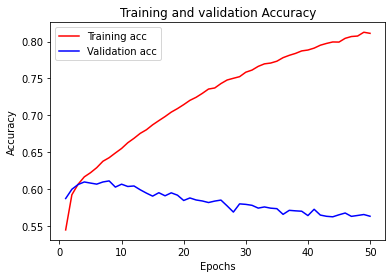

In [17]:
# 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.savefig('50_epocas_LSTM:64_vocab_size:1000_Embeddind:Zerado_tknzr:WordPunctTokenizer_Accuracy.jpg')
plt.show()

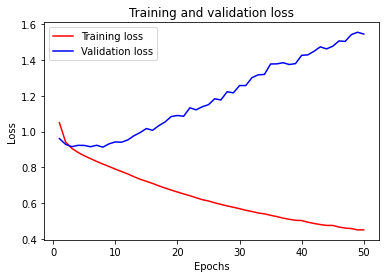

In [18]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('50_epocas_LSTM:64_vocab_size:1000_Embeddind:Zerado_tknzr:WordPunctTokenizer_Loss.jpg')
plt.show()